<a href="https://colab.research.google.com/github/AmineBAA/Deep-Insights_Neural-Network/blob/main/Resnet_TorchVision_Interpret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Interpretation for Pretrained ResNet Model: Neural activation classification with Autoencoder

This notebook demonstrates how to apply model interpretability algorithms on pretrained ResNet model using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image.

Captum library privides function of Layer Conductance, that helps to evaluate importance of each neuron within a given Layer

In [ ]:
pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
dir(models)

## 1- Loading the model and the dataset


Loads pretrained Resnet model and sets it to eval mode

In [ ]:
model = models.resnet18(pretrained=True)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 273MB/s]


Downloads the list of classes/labels for ImageNet dataset and reads them into the memory

In [ ]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2023-09-10 11:40:34--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.153.46, 52.217.90.190, 52.216.142.46, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.153.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.002s  

2023-09-10 11:40:35 (14.5 MB/s) - ‘/root/.torch/models/imagenet_class_index.json’ saved [35363/35363]



In [ ]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Defines transformers and normalizing functions for the image.
It also loads an image from the `img/resnet/` folder that will be used for interpretation purposes.

In [ ]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('/content/concept/concept_1.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

Predict the class of the input image

In [ ]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: lion ( 0.9131245017051697 )


In [ ]:
pred_label_idx.item()

291

## 2- Gradient-based attribution

Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

In [ ]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)


Predicted: goldfinch ( 0.9933870434761047 )


Let's visualize the image and corresponding attributions by overlaying the latter on the image.

In [ ]:
model.features.denseblock1

In [ ]:
layer_conv=model.layer4

In [ ]:
layer_conv

In [ ]:
# Convert convolutional layer to fully connected

In [ ]:
dir(model)

## 3- Layer Conductance

In [ ]:
from captum.attr import LayerConductance
cond =LayerConductance(model, layer_conv)

In [ ]:
cond_vals = cond.attribute(input,target=291)  #11 class of 'goldfinch' in imagenet dataset
cond_vals = cond_vals.detach().numpy()

In [ ]:
cond_vals.shape

(1, 512, 7, 7)

In [ ]:
cond_vals_flatten=cond_vals.reshape((512,7*7))

In [ ]:
cond_vals_flatten.shape

(512, 49)

In [ ]:
plt.hist(cond_vals[50][0], 100);
plt.title("Neuron 50 Distribution")
plt.figure()
plt.hist(cond_vals[19][0], 100);
plt.title("Neuron 19 Distribution");

In [ ]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.4f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        cmap = plt.get_cmap('copper')
        norm = plt.Normalize(importances.min(), importances.max())
        colors = cmap(norm(importances))
        plt.bar(x_pos, importances, align='center',color=colors)
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)


Average Neuron Importances
0 :  -0.0007
1 :  0.0010
2 :  0.0022
3 :  0.0000
4 :  -0.0007
5 :  0.0062
6 :  0.0066
7 :  -0.0008
8 :  0.0002
9 :  0.0084
10 :  -0.0004
11 :  0.0006
12 :  -0.0001
13 :  0.0007
14 :  0.0002
15 :  -0.0001
16 :  -0.0000
17 :  -0.0004
18 :  -0.0004
19 :  0.0012
20 :  0.0010
21 :  0.0079
22 :  -0.0004
23 :  -0.0001
24 :  -0.0004
25 :  -0.0001
26 :  -0.0001
27 :  -0.0006
28 :  0.0065
29 :  -0.0014
30 :  -0.0001
31 :  0.0005
32 :  0.0018
33 :  0.0004
34 :  -0.0001
35 :  -0.0006
36 :  -0.0001
37 :  -0.0002
38 :  0.0005
39 :  -0.0001
40 :  0.0000
41 :  -0.0000
42 :  -0.0014
43 :  0.0075
44 :  -0.0006
45 :  -0.0004
46 :  0.0006
47 :  -0.0001
48 :  -0.0003
49 :  -0.0018
50 :  0.0001
51 :  0.0067
52 :  -0.0001
53 :  -0.0001
54 :  0.0005
55 :  -0.0001
56 :  -0.0009
57 :  0.0005
58 :  0.0006
59 :  0.0001
60 :  0.0017
61 :  0.0090
62 :  -0.0024
63 :  0.0004
64 :  0.0006
65 :  0.0023
66 :  -0.0010
67 :  -0.0001
68 :  -0.0003
69 :  -0.0000
70 :  -0.0006
71 :  -0.0002
72 :  0

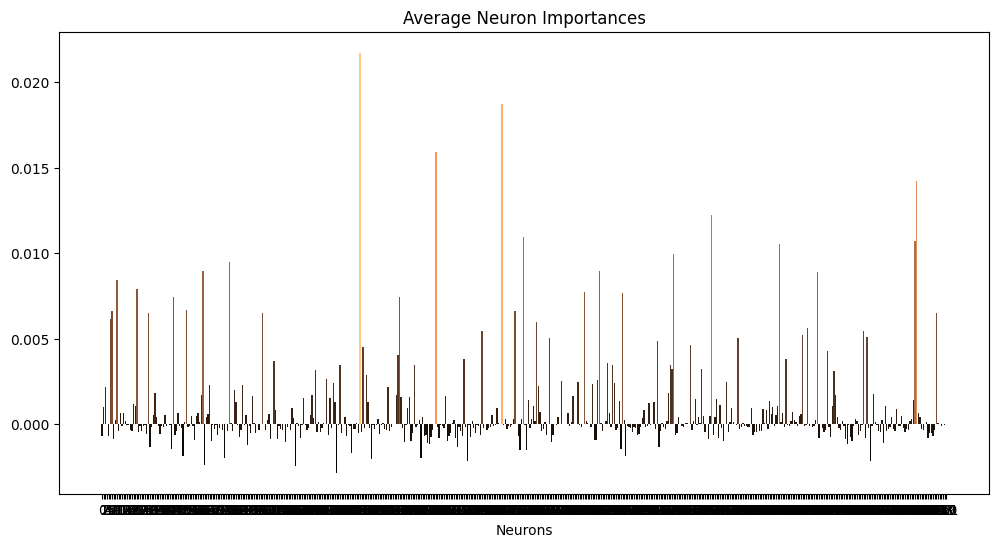

In [ ]:
visualize_importances(range(512),np.mean(cond_vals_flatten, axis=1),title="Average Neuron Importances", axis_title="Neurons")

In [ ]:
np.mean(cond_vals_flatten[17,])

-0.00033750583

In [ ]:
importance=np.mean(cond_vals_flatten, axis=1)
np.where(importance==np.max(importance))

(array([156]),)

In [ ]:
rang=np.where(importance==np.max(importance))
rang=np.mean(rang)

In [ ]:
rang=[76]

In [ ]:
vector=[]

for i in range(512):
  vector.append(np.mean(cond_vals_flatten[i,]))

In [ ]:
################################################################################

In [ ]:
### Rename files

import os
import glob

# Replace these values with your desired folder and renaming criteria
folder_path = '/content/concept'
file_extension = '.jpg'  # Change to the desired file extension
name_pattern = 'concept_{}'  # Change to your preferred name pattern

# Get a list of files that match the criteria
files_to_rename = glob.glob(os.path.join(folder_path, f"*{file_extension}"))

# Iterate through the files and rename them
for index, old_file_path in enumerate(files_to_rename):
    # Extract the file's base name without extension
    base_name = os.path.splitext(os.path.basename(old_file_path))[0]

    # Construct the new name using the pattern
    new_name = name_pattern.format(index + 1)

    # Create the new file path with the same extension as the old file
    new_file_path = os.path.join(folder_path, f"{new_name}{file_extension}")

    # Rename the file
    os.rename(old_file_path, new_file_path)

print("Files renamed successfully.")



Files renamed successfully.


In [ ]:
merged_array=vector
y=[prediction_score.squeeze().item()]
label=['lion']
for i in range(2,28):
  transform = transforms.Compose([ transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor()])
  transform_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
  img = Image.open('/content/concept/concept_'+str(i)+'.jpg')
  transformed_img = transform(img)
  input = transform_normalize(transformed_img)
  input = input.unsqueeze(0)
  output = model(input)
  output = F.softmax(output, dim=1)
  prediction_score, pred_label_idx = torch.topk(output, 1)
  pred_label_idx.squeeze_()
  predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
  y.append(prediction_score.squeeze().item())
  label.append(predicted_label)
  index=pred_label_idx.item()
  cond_vals = cond.attribute(input,target=index)
  cond_vals = cond_vals.detach().numpy()
  cond_vals_flatten=cond_vals.reshape((512,7*7))
  var=[]
  for j in range(512):
    var.append(np.mean(cond_vals_flatten[j,]))


  merged_array = np.column_stack((merged_array,var))
  rang.append(np.mean(np.where(np.mean(cond_vals_flatten, axis=1)==np.max(np.mean(cond_vals_flatten, axis=1)))))

In [ ]:
merged_array.shape

In [ ]:
len(label)

54

In [ ]:
############################################################################

In [ ]:
## Detect outlier neuron
def detect_outliers_zscore(data, threshold=4):
    z_scores = (data - data.mean()) / data.std()
    return np.where(np.abs(z_scores) > threshold)

outlier_indices = detect_outliers_zscore(importance)
print("Outlier indices:", outlier_indices)

Outlier indices: (array([156, 202, 242, 369, 493]),)


In [ ]:
outlier_indices[1].shape[0]

4

In [ ]:
All_data=merged_array

In [ ]:
#########################################

In [ ]:
All_data=np.concatenate((All_data,merged_array))

In [ ]:
All_data.shape

(4480, 299)

In [ ]:
X=pd.DataFrame(np.transpose(All_data))

## 4- Data processing

In [ ]:
import pandas as pd

In [ ]:
X=pd.DataFrame(np.transpose(merged_array))

In [ ]:
X_bis=pd.DataFrame(np.transpose(merged_array))

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.000075,-0.000472,0.000911,-0.000558,-0.000210,0.000728,0.000435,0.000249,-0.003544,-0.000089,...,0.000230,-0.000120,0.000022,-0.000243,0.000022,0.000352,0.003680,0.000468,-0.000218,0.002066
1,-0.000094,-0.000918,0.000047,-0.000788,0.000836,0.003866,-0.000262,0.000394,0.000972,0.001301,...,-0.002074,0.000675,0.000642,0.002054,0.000390,-0.000314,0.004354,0.000843,-0.001050,0.001511
2,-0.000301,-0.004723,-0.000028,-0.000488,-0.000082,0.000015,-0.000032,-0.000196,-0.001213,-0.000569,...,-0.000630,0.000387,0.000474,-0.001055,0.000648,-0.001065,0.003007,0.000007,-0.000189,0.001184
3,-0.000467,-0.000024,0.000575,-0.000436,-0.000581,0.001565,0.000517,0.000475,-0.003071,-0.000840,...,0.000679,-0.000076,0.000345,0.000296,-0.000462,0.000490,0.003847,-0.000157,0.000026,0.001716
4,-0.000211,0.000602,0.000401,0.000050,0.000215,-0.000028,-0.000181,0.000731,0.000742,0.000297,...,-0.000326,0.000312,0.000491,0.000495,0.000673,-0.001379,0.003167,-0.000271,0.000603,-0.000206


In [ ]:
label=pd.DataFrame(label)

In [ ]:
rang

In [ ]:
label.columns = ['y']

In [ ]:
data=[X,label]

In [ ]:
X_data=pd.concat(data,axis=1)

In [ ]:
X_data.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,y
0,0.000075,-0.000472,0.000911,-0.000558,-0.000210,0.000728,0.000435,0.000249,-0.003544,-0.000089,...,-0.000120,0.000022,-0.000243,0.000022,0.000352,0.003680,0.000468,-0.000218,0.002066,4
1,-0.000094,-0.000918,0.000047,-0.000788,0.000836,0.003866,-0.000262,0.000394,0.000972,0.001301,...,0.000675,0.000642,0.002054,0.000390,-0.000314,0.004354,0.000843,-0.001050,0.001511,4
2,-0.000301,-0.004723,-0.000028,-0.000488,-0.000082,0.000015,-0.000032,-0.000196,-0.001213,-0.000569,...,0.000387,0.000474,-0.001055,0.000648,-0.001065,0.003007,0.000007,-0.000189,0.001184,4
3,-0.000467,-0.000024,0.000575,-0.000436,-0.000581,0.001565,0.000517,0.000475,-0.003071,-0.000840,...,-0.000076,0.000345,0.000296,-0.000462,0.000490,0.003847,-0.000157,0.000026,0.001716,4
4,-0.000211,0.000602,0.000401,0.000050,0.000215,-0.000028,-0.000181,0.000731,0.000742,0.000297,...,0.000312,0.000491,0.000495,0.000673,-0.001379,0.003167,-0.000271,0.000603,-0.000206,4


In [ ]:
X_data["y"]=X_data["y"].astype('category')
X_data["y"]=X_data["y"].cat.codes

## 5- Data preparation

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from  sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.layers import  Dense, BatchNormalization, Activation, Add

In [ ]:
x_train=X_data.loc[:, X_data.columns != 'y']

In [ ]:
x_train=X

In [ ]:
x_train.shape

(54, 512)

In [ ]:
y_train=X_data['y']

In [ ]:
y_train=[1] * 54

In [ ]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [ ]:
scaler = MinMaxScaler()
x_concept=scaler.fit_transform(x_concept)

In [ ]:
x_train.shape

(54,)

In [ ]:
####################################""

In [ ]:
x_train_bis=X_bis

In [ ]:
y_train_bis=[0] * 27

In [ ]:
x_train_bis=np.array(x_train_bis)

In [ ]:
x_train_bis.shape

(27, 512)

In [ ]:
x_train_bis=np.array(x_train_bis)
y_train_bis=np.array(y_train_bis)

In [ ]:
x_concept=np.concatenate((x_train, x_train_bis))

In [ ]:
x_concept.shape

(81, 512)

In [ ]:
y_concept=np.concatenate((y_train, y_train_bis))

In [ ]:
y_concept.shape

(81,)

## 6- Autoencoder classifier

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model
import tensorflow.keras as keras
from keras import layers
import tensorflow as tf
from keras import regularizers

In [ ]:
encoding_dim=2
input=x_concept.shape[1]
# Deep NN
input_img = keras.Input(shape=(input,))
encoded = layers.Dense(200, activation='relu')(input_img)
encoded = layers.Dense(150, activation='relu')(encoded)
encoded = layers.Dense(100, activation='relu')(encoded)
encoded = layers.Dense(50, activation='relu')(encoded)
encoded = layers.Dense(20, activation='relu')(encoded)
encoded = layers.Dense(10, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='linear')(encoded)

decoded = layers.Dense(10, activation='relu')(encoded)
decoded = layers.Dense(20, activation='relu')(decoded)
decoded = layers.Dense(50, activation='relu')(decoded)
decoded = layers.Dense(100, activation='relu')(decoded)
decoded = layers.Dense(150, activation='relu')(decoded)
decoded = layers.Dense(200, activation='relu')(decoded)
decoded = layers.Dense(x_train.shape[1], activation='sigmoid')(decoded)

In [ ]:
autoencoder = keras.Model(input_img, decoded)

In [ ]:
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_56 (Dense)            (None, 200)               102600    
                                                                 
 dense_57 (Dense)            (None, 150)               30150     
                                                                 
 dense_58 (Dense)            (None, 100)               15100     
                                                                 
 dense_59 (Dense)            (None, 50)                5050      
                                                                 
 dense_60 (Dense)            (None, 20)                1020      
                                                                 
 dense_61 (Dense)            (None, 10)                210 

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_concept, x_concept,
                epochs=500,
                batch_size=256,
                shuffle=True,
                validation_data=(x_concept, x_concept)
                )

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 0.6931 - val_loss: 0.6929
Epoch 2/500
1/1 [==============================] - 0s 51ms/step - loss: 0.6929 - val_loss: 0.6925
Epoch 3/500
1/1 [==============================] - 0s 54ms/step - loss: 0.6925 - val_loss: 0.6920
Epoch 4/500
1/1 [==============================] - 0s 53ms/step - loss: 0.6920 - val_loss: 0.6910
Epoch 5/500
1/1 [==============================] - 0s 45ms/step - loss: 0.6910 - val_loss: 0.6894
Epoch 6/500
1/1 [==============================] - 0s 45ms/step - loss: 0.6894 - val_loss: 0.6866
Epoch 7/500
1/1 [==============================] - 0s 46ms/step - loss: 0.6866 - val_loss: 0.6820
Epoch 8/500
1/1 [==============================] - 0s 47ms/step - loss: 0.6820 - val_loss: 0.6749
Epoch 9/500
1/1 [==============================] - 0s 45ms/step - loss: 0.6749 - val_loss: 0.6647
Epoch 10/500
1/1 [==============================] - 0s 46ms/step - loss: 0.6647 - val_loss: 0.6515
Epoch 11/500
1/1 [===

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_concept)

3/3 [==============================] - 0s 4ms/step


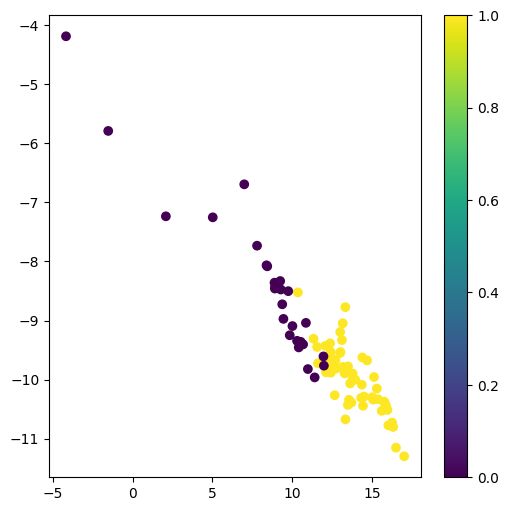

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_concept)
plt.colorbar()
plt.show()

In [ ]:
encoded_imgs

In [ ]:
np.where((encoded_imgs[:,0]>-23) & (encoded_imgs[:,0]<-15) & (encoded_imgs[:,1]<5) & (encoded_imgs[:,1]>0) )

(array([ 5, 18, 19, 28, 40, 44, 46, 51]),)

In [ ]:
len(np.unique(label))

50

In [ ]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('/content/animal_103.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: chimpanzee ( 0.9983150959014893 )
